# 2022 유행어

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('../data_inword/2022년 유행어.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20221128,"‘킹받네’, ‘가보자고’, ‘오히려 좋아’ 등 올 한 해도 많은 유행어와 신조어들이...",오늘은 <b>2022년<\/b> 중국에서는 어떤 <b>유행어<\/b>와 신조어들이 ...,2022년 중국 유행어 & 신조어 알아보기
1,20220510,안녕하세요! 벌써 2022년도 5월이 되었네요. 빠르게 가는 세월 속에 오늘은 20...,빠르게 가는 세월 속에 오늘은 <b>2022년 유행어<\/b>에 대해서 알아보는 시...,2022년 유행어 신조어 궁금했다면!
2,20230113,"안녕하세요. 세상에서 가장 쉬운 경제, 재테크 이야기를 전해드리는 주린이 Mr. k...",이번 포스팅에서는 먹쉬돈나 뜻을 비롯해 2022년에 유행했던 유행어가 무엇이 있었는...,"먹쉬돈나 뜻, 그 잡채 뜻 2022년 유행어 완벽 총정리"
3,20230105,2022년 중국에서 유행했던 유행어를 알아보자 2022년 중국 인터넷 유행어 9선 ...,<b>2022년<\/b> 중국에서 유행했던 <b>유행어<\/b>를 알아보자 <b>2...,2022년 중국에서 유행했던 유행어를 알아보자
4,20230202,안녕하세요! 남미숙 중국어 대학생 기자단 1기 이지영입니다. 이번 포스팅에서는 중국...,이번 포스팅에서는 중국의 문예월간지 '야오원자오즈 (咬文嚼字)'가 발표한 <b>20...,2022년 대륙을 달군 10대 유행어! (중국 사회 ver.)


## 1. 전처리

In [3]:
## 사용자 정의 단어 추가 
kiwi = Kiwi()

new = ['스불재', '어쩔티비', '어쩔', '저쩔', '캘박', '저메추', 'ㅈㄱㄴ', '제곧내', 
       '어사', '찐친', '먹쉬돈나', '중꺾마', '중요', '마음', '그잡채', '잡채', '모에모에', '큥', '뀽', '모에모에뀽', 
       '오이시쿠나레', '모에', '분조카', '분좋카', '농협은행', '넘흐옙흐네요', '통모짜핫도그', '요즘잘자쿨냥이',
       '오히려', '좋아', '킹', '킹받네', '케이지', '킹받드라슈', '킹파트라슈', '너뭐돼', '어쩔시크릿주주', '낭만']

for i in new:
    kiwi.add_user_word(i,'NNP')

In [4]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [5]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['사람', '코로나', '대하', '시작', '일본', '사용', '한국', '사랑', '때문', '중국', 
                        '사진', '미국', '사회', '영상', '단어', '표현', '블로그', '정도', '인기', '배우', 
                        '모습', '이야기', '활동', '세대', '출처', '세계', '마음', '친구', '가지', '유행', 
                        '행복', '작품', '출연', '이후', '상황', '다양', '관련', '최고', '멤버', '제공', 
                        '가능', '게임', '대상', '처음', '일상', '요즘', '보이', '여행', '진행', '프로그램', 
                        '시대', '소개', '성공', '느낌', '정보', '콘텐츠', '오늘', '생활', '내용', '기업', 
                        '투자', '경제', '대표', '캐릭터', '시장', '트렌드', '이름', '부분', '엄마', '필요', 
                        '가족', '기억', '이유', '인터넷', '경우', '성장', '세상', '관심', '당시', '공부', 
                        '감사', '마지막', '시즌', '등장', '기록', '사이', '준비', '인하', '영어', '데뷔', 
                        '발표', '공개', '개인', '나라', '중요', '자리', '회사', '여자', '서울', '기준', 
                        '채널', '운동', '대한민국', '변화', '소비', '제품', '경험', '가격', '감독', '추천', 
                        '기술', '포스팅', '학교', '하루', '스타', '나이', '유명', '이미지', '건강', '카페', 
                        '방법', '활용', '지금', '정리', '운영', '작년', '소리', '남자', '인생', '시절', 
                        '노력', '기사', '개그맨', '그룹', '화제', '브랜드', '일본어', '이해', '최근', '결과', 
                        '기대', '선택', '현실', '얼굴', '과거', '사건', '아이돌', '설명', '지역', '확인', 
                        '고민', '인간', '커피', '목표', '사실', '기분', '의미', '대학', '국민', '자체', 
                        '능력', '블로그', '기간', '본인', '증가', '선물', '국가', '순간', '계획', '아침', 
                        '용어', '작가', '분위기', '학생', '상승', '예정', '제목', '정책', '프로', '대신', 
                        '저녁', '선수', '리그', '상대', '경기', '달러', '유행어', '생각', '올해', '영화 ',
                        '화장품', '야구', '우승', '월드컵', '재미', '전체', '해당', '언니', '역사', '음식',
                        '연기', '감정', '행동', '무대', '인상', '주목', '플랫폼', '그림', '오랜만', '방식',
                        '중국어', '온라인', '인터뷰', '시험', '가수', '매력', '존재', '영향', '공간', '주식',
                        '주연', '국내', '정신', '분야', '대사', '뉴스', '연애', '개발', '환경', '부모', 
                        '예상', '방문', '모델', '평가', '광고', '아빠', '수준', '예능', '주인공', '산업', 
                        '여름', '아래', '정부', '공감', '지속', '이용', '언어', '서비스', '선정', '언급',
                        '년대', '지원', '진출', '수업', '참여', '마케팅', '포함', '개봉', '구매', '오빠',
                        '탄생', '거리', '축구', '공식', '시청', '과정', '결혼', '판매', '분석', '마무리',
                        '생일', '출시', '얘기', '메뉴', '식물', '미래', '인물', '만화', '추가', '네이버',
                        '시리즈', '현재' '기회', '시기', '중심', '수익', '상태', '자연', '조사', '여성',
                        '제작', '자료', '점심', '줄임', '역할', '현상', '특징', '주문', '단계', '머리',
                        '발전', '디지털', '에너지', '장면', '스토리', '목소리', '질문', '교육', '기자', '가치',
                        '결정', '부동산', '성격', '도움', '이벤트', '선생', '음악', '번역', '이전', '남편', 
                        '출신', '데이터', '학원', '스타일', '발생', '규모', '대회', '덕분', '오후', '일반',
                        '소식', '선거', '응원', '대화', '올림픽', '금리', '크리스마스', '도전', '플레이', '장소', 
                        '현대', '딸기', '상품', '패션', '대중', '눈물', '전문', '코너', '직원', '개월', '대통령', 
                        '키워드', '유지', '도시', '이제', '사업', '전쟁', '발매', '관리', '교수', '글로벌', 
                        '주요', '소비자', '청년', '경쟁', '주제', '유래', '직업'
                        ]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [6]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [7]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    # wordclass_column = 'wordclass_' + column 
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 29.3 s
Wall time: 3min 47s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20221128,킹받네 가보자고 오히려 좋아 등 올 한 해도 많은 유행어와 신조어들이 생겨났는데요 ...,오늘은 b2022년b 중국에서는 어떤 b유행어b와 신조어들이 많이 쓰였는지 알아보겠...,2022년 중국 유행어 신조어 알아보기,킹 해 신조어 은 신조어 바 바 일부 팀 고의 지 후 팀 순위 뒤 신입 영입 대비 ...,은 신조어 바 바 일부 팀 고의 지 후 팀 순위 뒤 신입,신조어
1,20220510,안녕하세요 벌써 2022년도 5월이 되었네요 빠르게 가는 세월 속에 오늘은 2022...,빠르게 가는 세월 속에 오늘은 b2022년 유행어b에 대해서 알아보는 시간을 가지려...,2022년 유행어 신조어 궁금했다면,년도 세월 속 신조어 뜻 지 인싸 번 스불 알 시 스불재 은 앞 글자 따 말 재앙 ...,세월 속 신조어 뜻 지 인싸 번 스불,신조어 궁금
2,20230113,안녕하세요 세상에서 가장 쉬운 경제 재테크 이야기를 전해드리는 주린이 Mr kim ...,이번 포스팅에서는 먹쉬돈나 뜻을 비롯해 2022년에 유행했던 유행어가 무엇이 있었는...,먹쉬돈나 뜻 그 잡채 뜻 2022년 유행어 완벽 총정리,재테크 전하 주리 킴 먹쉬 뜻 총 보 픽사 베이 먹쉬돈 뜻 먹쉬돈 뜻 즉석 떡볶이 ...,먹 돈 뜻 총 중꺾마 뜻 연말 초,먹쉬 돈 뜻 잡채 뜻 완벽
3,20230105,2022년 중국에서 유행했던 유행어를 알아보자 2022년 중국 인터넷 유행어 9선 ...,b2022년b 중국에서 유행했던 b유행어b를 알아보자 b2022년b 중국 인터넷 b...,2022년 중국에서 유행했던 유행어를 알아보자,선 도 번 적 개 면 점 수 점 번 중간중간 학업 부정 면 수 적 문제 점 장기 봉...,안녕하세요,
4,20230202,안녕하세요 남미숙 중국어 대학생 기자단 1기 이지영입니다 이번 포스팅에서는 중국의 ...,이번 포스팅에서는 중국의 문예월간지 야오원자오즈 가 발표한 b2022년b 10대 b...,2022년 대륙을 달군 10대 유행어 중국 사회 ver,안녕하세요 남 미숙 기자단 기 이지영 문예 월간지 야오원자오즈가 해 대륙 분발 용감...,문예 월간지 야오원자오즈가 해 대륙,대륙 달 대


In [8]:
# 전처리한 결과 csv로 저장 
df.to_csv('22유행어_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [9]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts


### [preprocessed_body]

In [10]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [11]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
17130,영화,834
6015,드라마,787
14702,신조어,637
9626,방송,475
8664,문화,416
8636,문제,393
4253,노래,359
18940,유튜브,339
4207,넷플릭스,216
14159,스포츠,213


In [12]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['영화',
 '드라마',
 '신조어',
 '방송',
 '문화',
 '문제',
 '노래',
 '유튜브',
 '넷플릭스',
 '스포츠',
 '루피',
 '김주연',
 '소설',
 '기회',
 '현재',
 '긍정',
 '테스트',
 '부문',
 '댓글',
 '리뷰',
 '다나카',
 '생산',
 '동생',
 '업무',
 '도착',
 '전국',
 '특별',
 '생기',
 '행사',
 '포기']

In [13]:
## 한 번 해본 것

for i in all_words_body['word']:
    if i in new:
        count = all_words_body.loc[all_words_body['word'] == i, 'count'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '중꺾마' is: 61
The count for '잡채' is: 53
The count for '낭만' is: 51
The count for '저메추' is: 31
The count for '스불재' is: 26
The count for '오이시쿠나레' is: 20
The count for '어쩔티비' is: 13
The count for '캘박' is: 12
The count for '농협은행' is: 11
The count for '킹받네' is: 10
The count for '어사' is: 6
The count for '모에' is: 6
The count for '킹받드라슈' is: 4
The count for '저쩔' is: 4
The count for '모에모에' is: 4
The count for '제곧내' is: 3
The count for '찐친' is: 2
The count for '모에모에뀽' is: 2
The count for '분좋카' is: 2
The count for '마음' is: 2
The count for '케이지' is: 1
The count for '너뭐돼' is: 1
The count for '먹쉬돈나' is: 1
The count for '중요' is: 1


### [preprocessed_description]

In [14]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
1150,신조어,61
1538,일기,30
2056,프로필,26
1321,영화,24
480,드라마,19
2193,후기,18
1840,출연진,17
676,문화,17
269,김주연,16
1526,인스타,14


### [preprocessed_title]

In [15]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
2170,신조어,127
906,드라마,44
1432,방송,37
2521,영화,35
3409,짬뽕,24
2473,연말,23
120,거지,21
3536,최신,21
2800,유튜브,20
506,김주연,20


# 3. TF-IDF

In [16]:
# ## 참고 사이트
# ## -> https://foreverhappiness.tistory.com/30
# ## -> https://foreverhappiness.tistory.com/35
# ## -> https://foreverhappiness.tistory.com/37
# ## 너무 오래 걸려서 안 돌림


# import pandas as pd
# from tqdm import tqdm
# from konlpy.tag import Okt
# from sklearn.feature_extraction.text import CountVectorizer

# # DTM (Document-Term Matrix) creation using Scikit-Learn's CountVectorizer
# # DTM(Document-Term Matrix) 생성 함수
# def NLP_DTM(df):
#     # 타이틀 리스트를 데이터프레임의 'preprocessed_title' 열에서 가져옴
#     title_lst = df['preprocessed_title']
    
#     # 불용어 리스트를 정의
#     stop_words_list = ['사람', '대하']
    
#     # Okt 형태소 분석기를 초기화
#     tagger = Okt()

#     # 결과를 저장할 DataFrame 초기화
#     result_df = pd.DataFrame()

#     # 타이틀 리스트를 순회하며 진행도를 표시
#     for title in tqdm(title_lst, desc='타이틀 리스트 진행도'):
#         # CountVectorizer 객체를 초기화
#         cv = CountVectorizer()

#         # 각 문서의 말뭉치를 저장할 리스트를 초기화
#         corpus = []

#         # 문서 진행도를 표시하며 타이틀 리스트의 각 요소에 대해 반복
#         for i in tqdm(range(len(df['preprocessed_body'])), desc='문서 진행도'):
#             # 각 타이틀에 대해 명사 리스트를 생성합니다.
#             n_lst = tagger.nouns(df['preprocessed_body'].iloc[i])
#             corpus.append(' '.join(n_lst))

#         # 말뭉치 데이터를 사용해 DTM(Document-Term Matrix)을 생성
#         DTM_array = cv.fit_transform(corpus).toarray()
        
#         # DTM의 각 열이 어떤 단어에 해당하는지 feature_names에 저장
#         feature_names = cv.get_feature_names_out()

#         # DTM 배열을 DataFrame 형식으로 변환
#         DTM_df = pd.DataFrame(DTM_array, columns=feature_names)
        
#         # 불용어 리스트에 있는 단어들을 DTM DataFrame에서 제거
#         DTM_df.drop(columns=stop_words_list, inplace=True, errors='ignore')
        
#         # 결과 DataFrame에 현재 DTM DataFrame을 추가
#         result_df = pd.concat([result_df, DTM_df], axis=0)

#     return result_df


# # %%time
# dtm_df = NLP_DTM(df)
# dtm_df

## 교수님 코드

In [17]:
## DTM (Document Term Matrix)
## 이거 안 하고 바로 TF-IDF로 가도 됨

import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer


documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
results = vector.fit_transform(documents).toarray()

results

array([[3, 1, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
## TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
dtm = vector.fit_transform(documents).toarray()


vector = TfidfVectorizer(vocabulary=word_dict)
tfidf = vector.fit_transform(documents).toarray()

tfidf

array([[0.26038533, 0.08640285, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.26000731, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18226204, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 가정: df는 미리 전처리된 텍스트 데이터 프레임
documents = df['preprocessed_body']
word_dict = all_word_counts['word'].tolist()

# TF-IDF 계산
vectorizer = TfidfVectorizer(vocabulary=word_dict)
tfidf_matrix = vectorizer.fit_transform(documents).toarray()

# 각 단어의 TF-IDF 값을 집계
tfidf_scores = tfidf_matrix.sum(axis=0)
words = vectorizer.get_feature_names_out()

# 데이터 프레임 생성
tfidf_df = pd.DataFrame({'words': words, 'counts': tfidf_scores})

# TF-IDF 값이 큰 순서로 정렬
tfidf_df = tfidf_df.sort_values(by='counts', ascending=False).reset_index(drop=True)


tfidf_df

,words,counts
0,본문,39.862104
1,신조어,29.891891
2,영화,21.831994
3,드라마,19.788503
4,방송,14.053048
...,...,...
3918,캐치티니핑,0.000000
3919,망사,0.000000
3920,드립은,0.000000
3921,성광,0.000000


In [20]:
## 한 번 해본 것

for i in tfidf_df['words']:
    if i in new:
        count = tfidf_df.loc[tfidf_df['words'] == i, 'counts'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '중꺾마' is: 5.396337148752698
The count for '잡채' is: 4.540841912706
The count for '낭만' is: 3.404538628908202
The count for '저메추' is: 2.972731736014799
The count for '스불재' is: 2.5118182489351955
The count for '킹받네' is: 1.7040252967830738
The count for '오이시쿠나레' is: 1.6192324338371367
The count for '농협은행' is: 1.6012906294027147
The count for '어쩔티비' is: 1.2795257856455147
The count for '캘박' is: 1.233955099452442
The count for '모에' is: 0.686668286358799


# 4. 워드 클라우드

## 필요한 모듈 임포트

In [21]:
from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline

import konlpy

## WordCloud 클래스의 객체 생성

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [22]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [23]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'영화': 834,
 '드라마': 787,
 '신조어': 637,
 '방송': 475,
 '문화': 416,
 '문제': 393,
 '노래': 359,
 '유튜브': 339,
 '넷플릭스': 216,
 '스포츠': 213,
 '루피': 200,
 '김주연': 167,
 '소설': 149,
 '기회': 148,
 '현재': 147,
 '긍정': 141,
 '테스트': 139,
 '부문': 132,
 '댓글': 132,
 '리뷰': 132,
 '다나카': 131,
 '생산': 125,
 '동생': 124,
 '업무': 124,
 '도착': 124,
 '전국': 124,
 '특별': 124,
 '생기': 123,
 '행사': 123,
 '포기': 123,
 '추억': 122,
 '감동': 122,
 '센터': 122,
 '안녕하세요': 121,
 '유튜버': 121,
 '인정': 121,
 '연습': 121,
 '보컬': 121,
 '세븐': 120,
 '기본': 120,
 '일부': 120,
 '예전': 120,
 '연말': 119,
 '걱정': 119,
 '이슈': 119,
 '라면': 119,
 '발견': 119,
 '소속': 119,
 '겨울': 118,
 '부정': 118,
 '인테리어': 118,
 '집중': 118,
 '중간': 118,
 '동물': 117,
 '정치': 117,
 '아파트': 117,
 '예술': 117,
 '베트남': 117,
 '날씨': 117,
 '관계': 116,
 '웃음': 116,
 '인스타그램': 115,
 '수상': 115,
 '댄스': 115,
 '예약': 115,
 '전망': 114,
 '연예': 114,
 '새해': 114,
 '포인트': 114,
 '부산': 114,
 '매출': 113,
 '가상': 113,
 '실패': 113,
 '스승': 113,
 '자랑': 113,
 '촬영': 112,
 '바람': 112,
 '출생': 112,
 '위치': 112,
 '기능': 112,
 '연결': 111,
 '개그': 

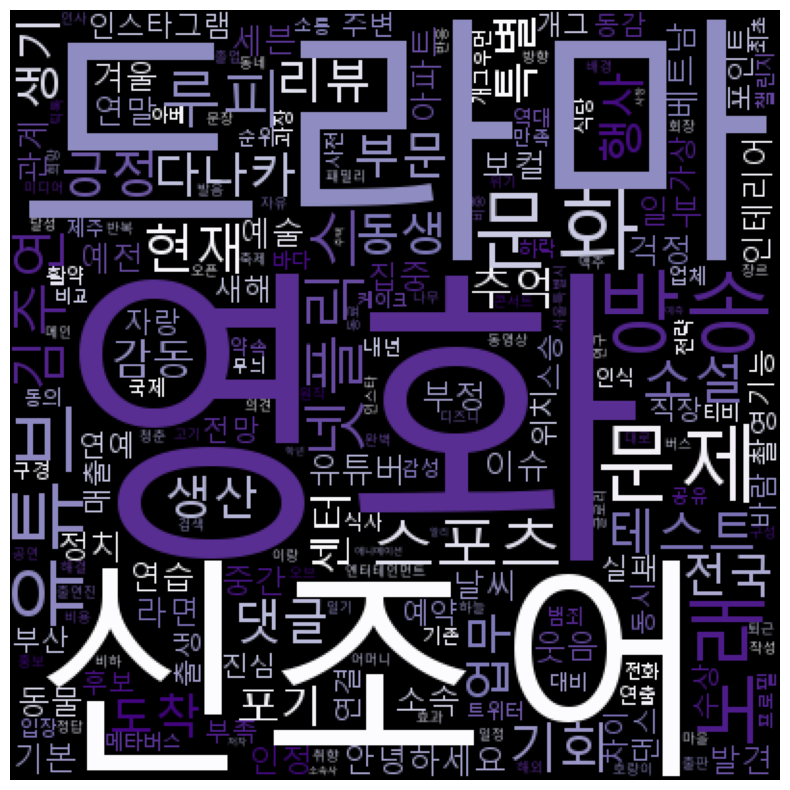

In [24]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Purples')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기